# **Part I** Data Pre-Processing

## 1. Read fiducial point and save as pickle files

In [ ]:
import scipy.io
import os
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_points(file):
    '''load matlab style file'''
    mat = scipy.io.loadmat(file)
    return mat[list(mat.keys())[3]]

def pickle_save(filename, content):
    '''save the file into python pickle object under output folder'''
    with open(filename, 'wb') as f:
        pickle.dump(content, f)
        
def pickle_open(filename):
    '''load the pickle file'''
    with open(filename, 'rb') as f:
        content = pickle.load(f)
    return content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read mat format file into pickle
dir_list = os.listdir('drive/My Drive/points')
dir_list.sort()

fiducial_pt_full = np.stack((get_points('drive/My Drive/points/'+filename) for filename in dir_list))
label_full = pd.read_csv('label.csv')['label']

# save the data into pickle files, so that we don't need to read raw data everytime
pickle_save('fiducial_pt_full', fiducial_pt_full)
pickle_save('label_full', label_full)

## 2. Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

# load data from pickle oject
fiducial_pt_full = pickle_open('fiducial_pt_full.pkl')
label_full = pickle_open('label_full.pkl')

## Note: randomly split into training & test set with seed 42
X_train, X_test, y_train, y_test = train_test_split(fiducial_pt_full, label_full, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_test.shape

((2400, 78, 2), (600,))

## 3. Feature Construction

Keep the fiducial points on eyes, eyebrows,and lips. Compute the pairwise distances.

In [ ]:
from sklearn.metrics import pairwise_distances
import time

# extract pairwise distance as features (78*77/2=3003 features)
# nrow=number of records of the dataset; ncol=3003
# keep 48 points on lips, eyes, and eyebrows, 48*47

start_time = time.time()
feature_train = np.stack((pairwise_distances(X_train[i])[np.triu_indices(48, k = 1)] for i in range(X_train.shape[0])))
print('Baseline training feature extraction takes %s seconds.'%round((time.time()-start_time),3))

start_time = time.time()
feature_test = np.stack((pairwise_distances(X_test[i])[np.triu_indices(48, k = 1)] for i in range(X_test.shape[0])))
print('Baseline training feature extraction takes %s seconds.'%round((time.time()-start_time),3))


Baseline training feature extraction takes 0.912 seconds.
Baseline training feature extraction takes 0.209 seconds.


# **Part II** Baseline Model: GBT

We optimized the baseline model with tuned parameters. Referencing main_draft.ipynb for more information.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score
import time

def clf_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    
    # reweight dataset in order to estimate the accuracy of "balanced" data set
    weight_data = np.zeros(len(y_true))
    for v in np.unique(y_true):
        weight_data[y_true==v] = 0.5*len(y_true)/np.sum(y_true==v)
    weighted_acc = np.sum(weight_data * (y_pred==y_true)/np.sum(weight_data))
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score, average='weighted')
    
    df = pd.DataFrame({'accuracy':[accuracy],'weighted acc':[weighted_acc],
                       'precision': [precision], 'recall': [recall], 'auc':[auc]})
    print(df)

In [ ]:
weights2 = np.zeros(len(y_train))
weights2[y_train == 0] = 1
weights2[y_train == 1] = 10

gbt_baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150,
                                      max_depth=4, min_samples_split=2, min_samples_leaf=1, 
                                      subsample=0.8,max_features='sqrt', random_state=299)
start = time.time()
gbt_baseline.fit(feature_train, y_train, sample_weight = weights2)
print('Training time cost {:.2f} s'.format(time.time()-start))

Training time cost 4.45 s


In [ ]:
# store the trained model
pickle_save('gbt_baseline', gbt_baseline)

# load the trained model from file
gbt_baseline = pickle_open('gbt_baseline')

In [ ]:
gbt_baseline.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 299,
 'subsample': 0.8,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Gradient boosting baseline model performance
pred_train = gbt_baseline.predict(feature_train)
score_train = gbt_baseline.decision_function(feature_train)
print('Training set:')
clf_metrics(y_train, pred_train, score_train)
print('\n')

pred_test = gbt_baseline.predict(feature_test)
score_test = gbt_baseline.decision_function(feature_test)
print('Test set:')
clf_metrics(y_test, pred_test, score_test)
print('\n')

Training set:
   accuracy  weighted acc  precision  recall       auc
0  0.930833      0.957239     0.7344     1.0  0.999494


Test set:
   accuracy  weighted acc  precision    recall       auc
0  0.736667      0.670344   0.444444  0.546763  0.730192




# **Part III** Our Model: Densely Connected Neural Network

## 1. Feature engineering

In [ ]:
import warnings
warnings.filterwarnings('ignore')
start_time = time.time()
feature_train = np.stack((pairwise_distances(X_train[i])[np.triu_indices(78, k = 1)] for i in range(X_train.shape[0])))
print('Training feature extraction takes %s seconds.'%round((time.time()-start_time),3))

start_time = time.time()
feature_test = np.stack((pairwise_distances(X_test[i])[np.triu_indices(78, k = 1)] for i in range(X_test.shape[0])))
print('Test feature extraction takes %s seconds.'%round((time.time()-start_time),3))


Training feature extraction takes 1.145 seconds.
Test feature extraction takes 0.269 seconds.


## 2. Oversampling the minority class

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

bool_train_labels = y_train != 0
pos_features = feature_train[bool_train_labels]
neg_features = feature_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [ ]:
pos_labels.shape, neg_labels.shape

((459,), (1941,))

In [ ]:
# Balance the dataset manually by choosing the right number of random indices from the positive examples
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(1941, 3003)

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape, resampled_labels.shape

((3882, 3003), (3882,))

## 3. Model Training

In [ ]:
from tensorflow import keras

METRICS = [
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall')
]
INPUT_SHAPE=[3003]
model1 = keras.Sequential([
                           keras.layers.BatchNormalization(input_shape=INPUT_SHAPE, 
                                                           momentum=0.80),
                           keras.layers.Dense(1024, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.3),
                           keras.layers.Dense(512, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.3),
                           keras.layers.Dense(256, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dense(128, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.3),
                           keras.layers.Dense(64, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.25),
                           keras.layers.Dense(32, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.1),
                           keras.layers.Dense(16, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(
      #optimizer=keras.optimizers.RMSprop(),
      optimizer=keras.optimizers.Adam(lr=0.001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(  
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3003)              12012     
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              3076096   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

In [ ]:
start_time = time.time()

EPOCHS=100
resampled_history = model1.fit(
    resampled_features, resampled_labels,
    epochs=EPOCHS,
    batch_size=64, 
    callbacks = [early_stopping],
    validation_split=0.2
    )

print("training  model takes %s seconds" % round((time.time() - start_time),3))

Epoch 1/100
49/49 [==============================] - 4s 72ms/step - loss: 0.7985 - accuracy: 0.4937 - auc: 0.4872 - precision: 0.4929 - recall: 0.5132 - val_loss: 0.6932 - val_accuracy: 0.5122 - val_auc: 0.5049 - val_precision: 0.5176 - val_recall: 0.4872
Epoch 2/100
49/49 [==============================] - 3s 60ms/step - loss: 0.7310 - accuracy: 0.4899 - auc: 0.4815 - precision: 0.4871 - recall: 0.4280 - val_loss: 0.6939 - val_accuracy: 0.5006 - val_auc: 0.5070 - val_precision: 0.5039 - val_recall: 0.6531
Epoch 3/100
49/49 [==============================] - 3s 60ms/step - loss: 0.7124 - accuracy: 0.5060 - auc: 0.5060 - precision: 0.5054 - recall: 0.4519 - val_loss: 0.6915 - val_accuracy: 0.5174 - val_auc: 0.5367 - val_precision: 0.5188 - val_recall: 0.5969
Epoch 4/100
49/49 [==============================] - 3s 60ms/step - loss: 0.7112 - accuracy: 0.4918 - auc: 0.4768 - precision: 0.4862 - recall: 0.3292 - val_loss: 0.6931 - val_accuracy: 0.4994 - val_auc: 0.5146 - val_precision: 0.58

In [ ]:
# calculate weighted accuracy on test data
pred_prob = model1.predict(feature_test).reshape(len(y_test))
pred_test = np.zeros(len(y_test))
pred_test[pred_prob>0.5] = 1

weight_test = np.zeros(len(y_test))
for v in np.unique(y_test):
    weight_test[y_test==v] = 0.5*len(y_test)/np.sum(y_test==v)
weighted_acc = np.sum(weight_test * (pred_test==y_test)/np.sum(weight_test))

In [ ]:
eval = model1.evaluate(feature_test, y_test)
print('Test accuracy: {:.2f}'.format(eval[1]))
print('Test weighted accuracy: {:.2f}'.format(weighted_acc))
print('Test auc: {:.2f}'.format(eval[2]))

19/19 [==============================] - 0s 9ms/step - loss: 0.7621 - accuracy: 0.8367 - auc: 0.8189 - precision: 0.6667 - recall: 0.5899
Test accuracy: 0.84
Test weighted accuracy: 0.75
Test auc: 0.82


## 4. Visualization

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['auc', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

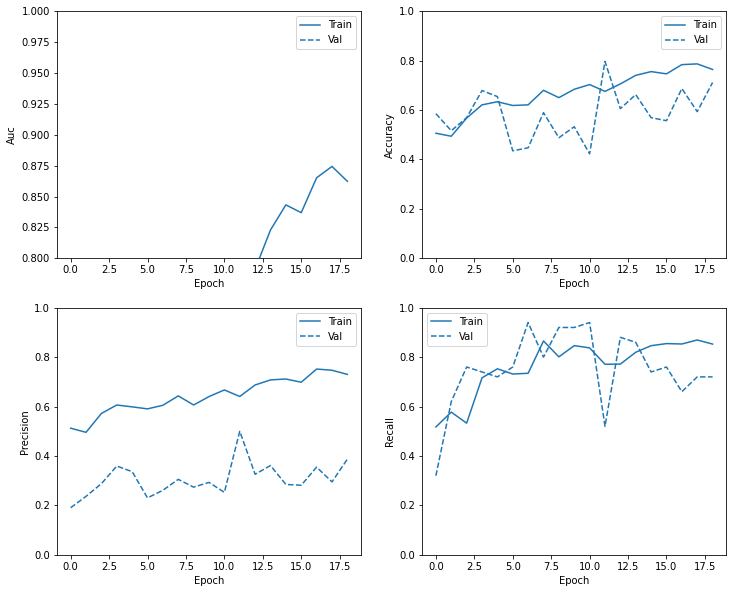

In [ ]:
plot_metrics(resampled_history)

## 5. Export the model

In [67]:
# save tensorflow model
!mkdir -p saved_model
model1.save('saved_model/NN') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/NN/assets


In [68]:
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)
model1.save(export_path_keras)

./1604422915.h5


# **Part IV** Comparison

The densely connected neural network is chosen from all the models we experimented for its running time and performance on accuracy and auc. The results and the links for other models we tried are shown below.

| Model      | Accuracy |  AUC    | Link|
| ----------- | ----------- | ------    |------|
| Baseline Model (GBT)      | 0.71       |  0.79   | [GBT](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/baseline_model_tuned.ipynb)|
| XGBoost   | 0.73       |  0.83|[XGBoost](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/XGBoost_tuned_2.ipynb)|
| Random Forest | 0.79 | 0.80 |[Random Forest](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/random_forest.ipynb) |
| SVM |0.72 |0.82| [SVM](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/SVM.ipynb)|
|Neural Networks|0.76 | 0.85| [NN](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/Neural_Network_train.ipynb)|
|CNN| 0.52 | 0.51 | [CNN](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/CNN.ipynb)|